<a href="https://colab.research.google.com/github/vedharshita/Detecting-Mental-Workload-in-Virtual-Reality/blob/main/2_Preprocessing%26MLModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Mental Workload in Virtual Reality Using EEG Spectral Data: A Deep Learning Approach

---



In [ ]:
## Mounting gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## Import Statements
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.model_selection import GridSearchCV

After extracting 5 feactures from 8 electrode positions (F3, Fz, F4, C3, C4, P3, Pz, P4) data, we now have 40 features to work on.

In [ ]:
## Setting path for data files on colab
root_dir = "/content/gdrive/MyDrive/VR Mental Workload/"
raw_dir = root_dir + "data/VRData2019/"
model_file_dir = raw_dir + "model_file_dir/"
os.chdir(model_file_dir)

In [ ]:
## Loading final csv in df
features_df = pd.read_csv(r'/content/gdrive/MyDrive/VR Mental Workload/data/VRData2019/model_file_dir/df.csv')
features_df = features_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
features_df = features_df.reindex(sorted(features_df.columns), axis=1)
features_df

train_df = pd.read_csv(r'/content/gdrive/MyDrive/VR Mental Workload/data/VRData2019/model_file_dir/train.csv')
train_df = train_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
train_df = train_df.reindex(sorted(train_df.columns), axis=1)
train_df

test_df = pd.read_csv(r'/content/gdrive/MyDrive/VR Mental Workload/data/VRData2019/model_file_dir/test.csv')
test_df = test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
test_df = test_df.reindex(sorted(test_df.columns), axis=1)
test_df

print(features_df.shape, train_df.shape, test_df.shape)

(13723, 41) (9148, 41) (4575, 41)


In [ ]:
print("Missing values:", features_df.isna().sum().sum())

Missing values: 0


In [ ]:
print("Non-numeric columns:", len(features_df.select_dtypes('object').columns))

Non-numeric columns: 0


In [ ]:
features_df.describe()

,nback,signal_1_Alpha,signal_1_Beta,signal_1_Delta,signal_1_Gamma,signal_1_Theta,signal_2_Alpha,signal_2_Beta,signal_2_Delta,signal_2_Gamma,signal_2_Theta,signal_3_Alpha,signal_3_Beta,signal_3_Delta,signal_3_Gamma,signal_3_Theta,signal_4_Alpha,signal_4_Beta,signal_4_Delta,signal_4_Gamma,signal_4_Theta,signal_5_Alpha,signal_5_Beta,signal_5_Delta,signal_5_Gamma,signal_5_Theta,signal_6_Alpha,signal_6_Beta,signal_6_Delta,signal_6_Gamma,signal_6_Theta,signal_7_Alpha,signal_7_Beta,signal_7_Delta,signal_7_Gamma,signal_7_Theta,signal_8_Alpha,signal_8_Beta,signal_8_Delta,signal_8_Gamma,signal_8_Theta
count,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000
mean,1.000146,0.191465,0.176912,0.206040,0.141880,0.197694,0.233119,0.208757,0.239350,0.180801,0.240311,0.220801,0.193489,0.230764,0.157315,0.230405,0.237687,0.220077,0.227256,0.170628,0.221458,0.229170,0.204604,0.220244,0.173644,0.215723,0.241245,0.244713,0.200993,0.212962,0.218484,0.246390,0.239246,0.212508,0.224027,0.244277,0.260344,0.232114,0.215286,0.215555,0.232570
std,0.816497,0.162351,0.154497,0.185679,0.136562,0.177835,0.171536,0.159687,0.196902,0.154647,0.188941,0.171182,0.162891,0.191112,0.147666,0.193045,0.178497,0.171132,0.188918,0.156558,0.175110,0.174461,0.161511,0.176635,0.165912,0.174526,0.183759,0.186275,0.178679,0.173850,0.177615,0.177004,0.174603,0.176773,0.172237,0.187237,0.182419,0.170047,0.175182,0.173011,0.178367
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.076809,0.066793,0.068412,0.052328,0.065948,0.107427,0.095880,0.089639,0.074673,0.096959,0.096752,0.080807,0.084746,0.058808,0.084757,0.098832,0.094308,0.086021,0.060833,0.088760,0.093496,0.087170,0.089582,0.054281,0.085085,0.093386,0.095158,0.069718,0.082825,0.078216,0.108693,0.105300,0.087089,0.096728,0.094961,0.115272,0.101684,0.090795,0.086829,0.093889
50%,1.000000,0.149163,0.134665,0.147220,0.103960,0.141517,0.195355,0.169933,0.178615,0.142108,0.186303,0.182959,0.151310,0.176402,0.112075,0.169390,0.197176,0.171623,0.175099,0.119954,0.179769,0.190745,0.160167,0.176269,0.121229,0.169640,0.204384,0.207066,0.149073,0.170407,0.177190,0.211688,0.203420,0.168077,0.184067,0.205194,0.233091,0.197141,0.172806,0.169887,0.196760
75%,2.000000,0.258305,0.238461,0.288784,0.186456,0.279917,0.313991,0.277405,0.342100,0.239104,0.341674,0.297875,0.256372,0.321845,0.203606,0.327760,0.333951,0.304518,0.310687,0.232709,0.306979,0.318665,0.282098,0.299360,0.238131,0.300906,0.344798,0.352426,0.274340,0.293549,0.308864,0.344833,0.334919,0.284036,0.309808,0.346517,0.364928,0.322182,0.287472,0.303628,0.325987
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
## Get pos of columns for EDA
pos = dict()
for c in features_df.columns:
  pos[features_df.columns.get_loc(c)] = c
print(pos)

{0: 'nback', 1: 'signal_1_Alpha', 2: 'signal_1_Beta', 3: 'signal_1_Delta', 4: 'signal_1_Gamma', 5: 'signal_1_Theta', 6: 'signal_2_Alpha', 7: 'signal_2_Beta', 8: 'signal_2_Delta', 9: 'signal_2_Gamma', 10: 'signal_2_Theta', 11: 'signal_3_Alpha', 12: 'signal_3_Beta', 13: 'signal_3_Delta', 14: 'signal_3_Gamma', 15: 'signal_3_Theta', 16: 'signal_4_Alpha', 17: 'signal_4_Beta', 18: 'signal_4_Delta', 19: 'signal_4_Gamma', 20: 'signal_4_Theta', 21: 'signal_5_Alpha', 22: 'signal_5_Beta', 23: 'signal_5_Delta', 24: 'signal_5_Gamma', 25: 'signal_5_Theta', 26: 'signal_6_Alpha', 27: 'signal_6_Beta', 28: 'signal_6_Delta', 29: 'signal_6_Gamma', 30: 'signal_6_Theta', 31: 'signal_7_Alpha', 32: 'signal_7_Beta', 33: 'signal_7_Delta', 34: 'signal_7_Gamma', 35: 'signal_7_Theta', 36: 'signal_8_Alpha', 37: 'signal_8_Beta', 38: 'signal_8_Delta', 39: 'signal_8_Gamma', 40: 'signal_8_Theta'}


In [ ]:
## Get features for EDA
alphas = [features_df.columns[1],features_df.columns[6],features_df.columns[11],features_df.columns[16],features_df.columns[21],features_df.columns[26],features_df.columns[31],features_df.columns[36]]
betas = [features_df.columns[2],features_df.columns[7],features_df.columns[12],features_df.columns[17],features_df.columns[22],features_df.columns[27],features_df.columns[32],features_df.columns[37]]
deltas = [features_df.columns[3],features_df.columns[8],features_df.columns[13],features_df.columns[18],features_df.columns[23],features_df.columns[28],features_df.columns[33],features_df.columns[38]]
gammas = [features_df.columns[4],features_df.columns[9],features_df.columns[14],features_df.columns[19],features_df.columns[24],features_df.columns[29],features_df.columns[34],features_df.columns[39]]
thetas = [features_df.columns[5],features_df.columns[10],features_df.columns[15],features_df.columns[20],features_df.columns[25],features_df.columns[30],features_df.columns[35],features_df.columns[40]]
print("Alpha: ",alphas)
print("Beta: ", betas)
print("Delta: ", deltas)
print("Gamma: ", gammas)
print("Theta: ", thetas)

Alpha:  ['signal_1_Alpha', 'signal_2_Alpha', 'signal_3_Alpha', 'signal_4_Alpha', 'signal_5_Alpha', 'signal_6_Alpha', 'signal_7_Alpha', 'signal_8_Alpha']
Beta:  ['signal_1_Beta', 'signal_2_Beta', 'signal_3_Beta', 'signal_4_Beta', 'signal_5_Beta', 'signal_6_Beta', 'signal_7_Beta', 'signal_8_Beta']
Delta:  ['signal_1_Delta', 'signal_2_Delta', 'signal_3_Delta', 'signal_4_Delta', 'signal_5_Delta', 'signal_6_Delta', 'signal_7_Delta', 'signal_8_Delta']
Gamma:  ['signal_1_Gamma', 'signal_2_Gamma', 'signal_3_Gamma', 'signal_4_Gamma', 'signal_5_Gamma', 'signal_6_Gamma', 'signal_7_Gamma', 'signal_8_Gamma']
Theta:  ['signal_1_Theta', 'signal_2_Theta', 'signal_3_Theta', 'signal_4_Theta', 'signal_5_Theta', 'signal_6_Theta', 'signal_7_Theta', 'signal_8_Theta']


### **STEP 4: EDA - with all feature bands**



[Text(0.5, 0, 'Theta Signal Distribution')]

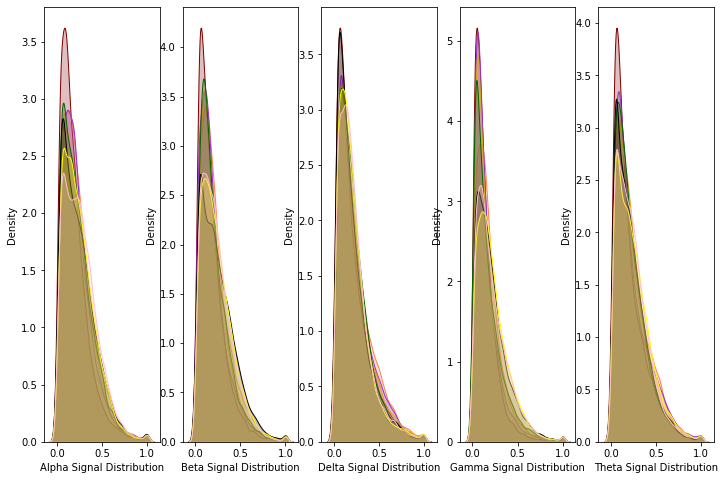

In [ ]:
## Plot5 Signal Distribution/Univariate Analysis
fig, axes = plt.subplots(1, 5, figsize=(12, 8))
colours = ["maroon","coral","darkorchid","goldenrod","darkgreen","black","yellow","pink"]
index = -1
for i in alphas:
    index = index + 1
    fig = sns.kdeplot(features_df[i] , shade=True, color=colours[index], ax=axes[0])

index = -1
for i in betas:
    index = index + 1
    fig = sns.kdeplot(features_df[i] , shade=True, color=colours[index], ax=axes[1])

index = -1
for i in deltas:
    index = index + 1
    fig = sns.kdeplot(features_df[i] , shade=True, color=colours[index], ax=axes[2])

index = -1
for i in gammas:
    index = index + 1
    fig = sns.kdeplot(features_df[i] , shade=True, color=colours[index], ax=axes[3])

index = -1
for i in thetas:
    index = index + 1
    fig = sns.kdeplot(features_df[i] , shade=True, color=colours[index], ax=axes[4])

axes[0].set(xlabel="Alpha Signal Distribution")
axes[1].set(xlabel="Beta Signal Distribution")
axes[2].set(xlabel="Delta Signal Distribution")
axes[3].set(xlabel="Gamma Signal Distribution")
axes[4].set(xlabel="Theta Signal Distribution")

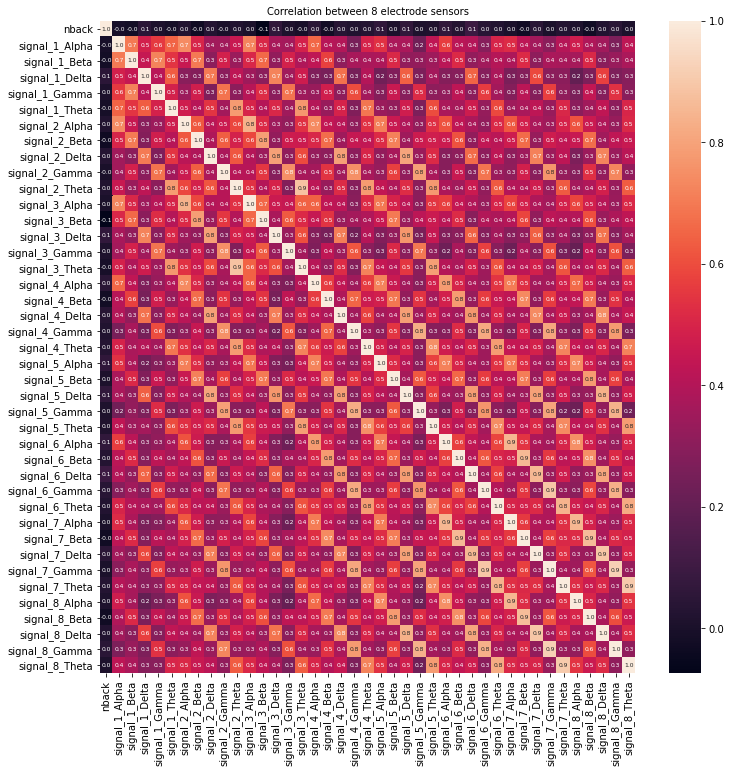

In [ ]:
## Plot 6, Correlations within signals
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
sns.heatmap(features_df.corr(), annot=True, fmt=".1f", annot_kws={"fontsize":6})
plt.title("Correlation between 8 electrode sensors",fontsize=10)
plt.show()

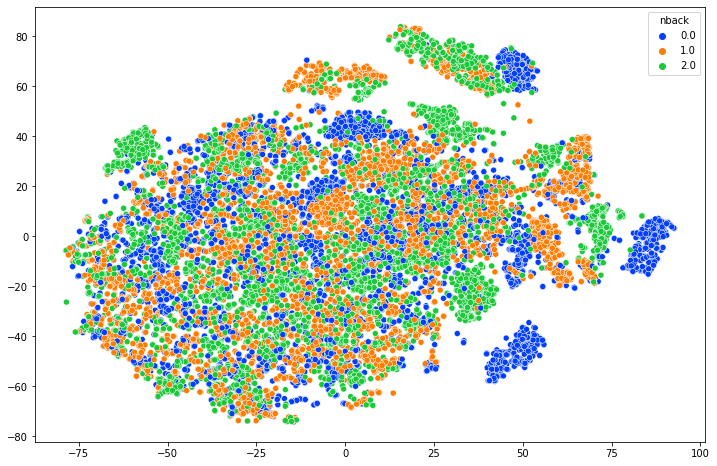

In [ ]:
## Plot 7 Visualising high-dimensions using TSNE
X = features_df[features_df.columns[1:]]
tsne = TSNE(random_state = 42, n_components=2, perplexity=25, n_iter=1000).fit_transform(X)
plt.figure(figsize=(12,8))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = features_df["nback"],palette="bright")

In [ ]:
## Feature scaling - StandardScaler -- Standardize features by removing the mean and scaling to unit variance and Train Test Split
X = features_df[features_df.columns[1:]]
y = features_df['nback']

X_train = train_df[train_df.columns[1:]]
X_test = test_df[test_df.columns[1:]]
y_train = train_df['nback']
y_test = test_df['nback']

### **STEP 5: ML Modeling**


In [ ]:
## Fitting Logistic Regression to the Training set
classifier = LogisticRegression(random_state = 0, max_iter = 1500)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

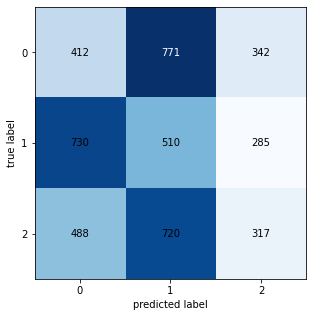

              precision    recall  f1-score   support

           0       0.25      0.27      0.26      1525
           1       0.25      0.33      0.29      1525
           2       0.34      0.21      0.26      1525

    accuracy                           0.27      4575
   macro avg       0.28      0.27      0.27      4575
weighted avg       0.28      0.27      0.27      4575

Accuracy by Logistic Regression with All feature set is 27.081967213114755


In [ ]:
## Predicting the Logistic Test set results
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 5))
plt.show()

## Classification Report and Accuracy
print(classification_report(y_test, y_pred))
accuracy_score = accuracy_score(y_test,y_pred)
print("Accuracy by Logistic Regression with All feature set is", accuracy_score*100)

In [ ]:
# ## Tree-based Feature Selection
# clf = ExtraTreesClassifier()
# clf = clf.fit(X_train, y_train)
# model = SelectFromModel(clf, prefit=True)
# New_features = model.transform(X_train)
# print(New_features.shape)

# feature_idx = model.get_support()
# feature_name = X.columns[feature_idx]
# feature_name

# test_features = model.transform(X_test)

(9148, 16)


In [ ]:
# ## L1-based feature selection
# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
# model_2 = SelectFromModel(lsvc, prefit=True)
# New_features_2 = model_2.transform(X_train)
# print(New_features_2.shape)

# feature_idx = model.get_support()
# feature_name = X.columns[feature_idx]
# feature_name

# test_features_2 = model_2.transform(X_test)

(9148, 22)


NaiveBayesClassifier--Accuracy: 0.22 (+/- 0.18)


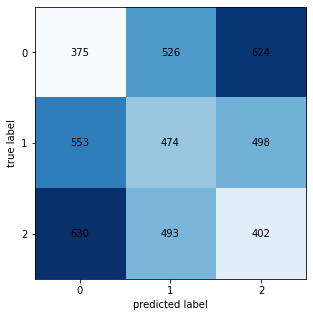

i                precision    recall  f1-score   support

           0       0.24      0.25      0.24      1525
           1       0.32      0.31      0.31      1525
           2       0.26      0.26      0.26      1525

    accuracy                           0.27      4575
   macro avg       0.27      0.27      0.27      4575
weighted avg       0.27      0.27      0.27      4575

RandomForestClassifier--Accuracy: 0.27 (+/- 0.16)


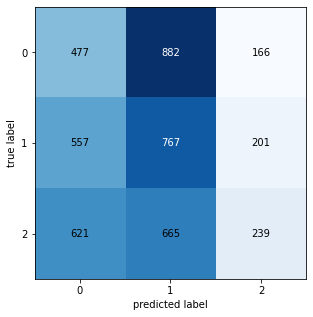

i                precision    recall  f1-score   support

           0       0.29      0.31      0.30      1525
           1       0.33      0.50      0.40      1525
           2       0.39      0.16      0.22      1525

    accuracy                           0.32      4575
   macro avg       0.34      0.32      0.31      4575
weighted avg       0.34      0.32      0.31      4575

KNeighborsClassifier--Accuracy: 0.28 (+/- 0.13)


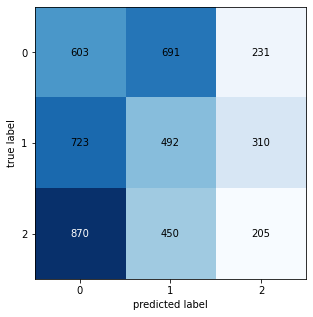

i                precision    recall  f1-score   support

           0       0.27      0.40      0.32      1525
           1       0.30      0.32      0.31      1525
           2       0.27      0.13      0.18      1525

    accuracy                           0.28      4575
   macro avg       0.28      0.28      0.27      4575
weighted avg       0.28      0.28      0.27      4575

GradientBoostingClassifier--Accuracy: 0.27 (+/- 0.16)


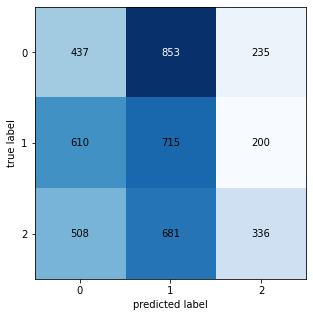

i                precision    recall  f1-score   support

           0       0.28      0.29      0.28      1525
           1       0.32      0.47      0.38      1525
           2       0.44      0.22      0.29      1525

    accuracy                           0.33      4575
   macro avg       0.34      0.33      0.32      4575
weighted avg       0.34      0.33      0.32      4575

AdaBoostClassifier--Accuracy: 0.26 (+/- 0.17)


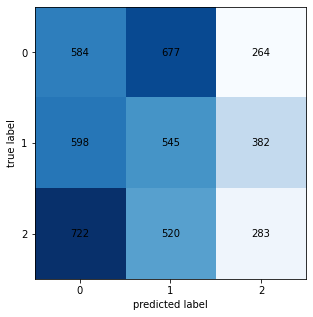

i                precision    recall  f1-score   support

           0       0.31      0.38      0.34      1525
           1       0.31      0.36      0.33      1525
           2       0.30      0.19      0.23      1525

    accuracy                           0.31      4575
   macro avg       0.31      0.31      0.30      4575
weighted avg       0.31      0.31      0.30      4575

DecisionTreeClassifier--Accuracy: 0.32 (+/- 0.08)


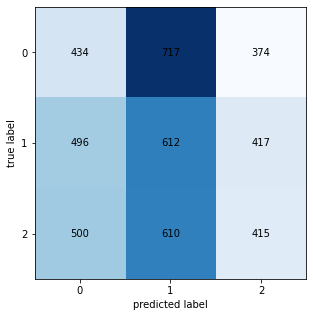

i                precision    recall  f1-score   support

           0       0.30      0.28      0.29      1525
           1       0.32      0.40      0.35      1525
           2       0.34      0.27      0.30      1525

    accuracy                           0.32      4575
   macro avg       0.32      0.32      0.32      4575
weighted avg       0.32      0.32      0.32      4575



In [ ]:
## Modelling with whole feature set
model_name=['NaiveBayesClassifier','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']
models_list= [NB(),RF(),KNN(),GB(),AB(),DT()]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, X_train, y_train, cv = 10)
    print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


    classifier = j
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 5))
    plt.show()
    print("i ",classification_report(y_test, y_pred))

NaiveBayesClassifier--Accuracy: 0.25 (+/- 0.24)


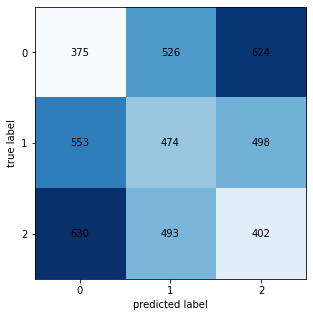

i                precision    recall  f1-score   support

           0       0.24      0.25      0.24      1525
           1       0.32      0.31      0.31      1525
           2       0.26      0.26      0.26      1525

    accuracy                           0.27      4575
   macro avg       0.27      0.27      0.27      4575
weighted avg       0.27      0.27      0.27      4575

RandomForestClassifier--Accuracy: 0.32 (+/- 0.17)


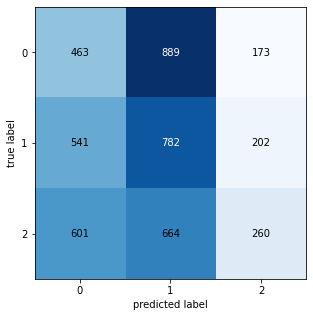

i                precision    recall  f1-score   support

           0       0.29      0.30      0.30      1525
           1       0.33      0.51      0.41      1525
           2       0.41      0.17      0.24      1525

    accuracy                           0.33      4575
   macro avg       0.34      0.33      0.31      4575
weighted avg       0.34      0.33      0.31      4575

KNeighborsClassifier--Accuracy: 0.32 (+/- 0.12)


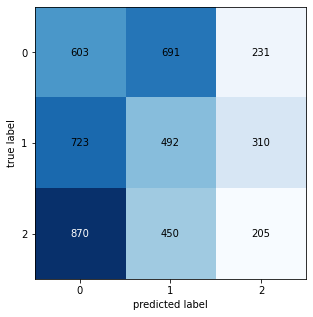

i                precision    recall  f1-score   support

           0       0.27      0.40      0.32      1525
           1       0.30      0.32      0.31      1525
           2       0.27      0.13      0.18      1525

    accuracy                           0.28      4575
   macro avg       0.28      0.28      0.27      4575
weighted avg       0.28      0.28      0.27      4575

GradientBoostingClassifier--Accuracy: 0.31 (+/- 0.15)


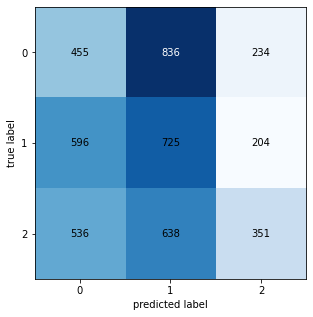

i                precision    recall  f1-score   support

           0       0.29      0.30      0.29      1525
           1       0.33      0.48      0.39      1525
           2       0.44      0.23      0.30      1525

    accuracy                           0.33      4575
   macro avg       0.35      0.33      0.33      4575
weighted avg       0.35      0.33      0.33      4575

AdaBoostClassifier--Accuracy: 0.29 (+/- 0.19)


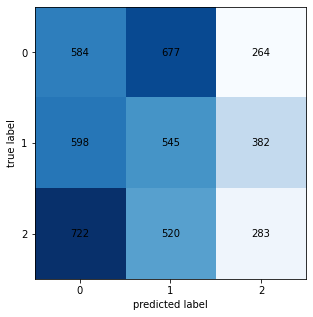

i                precision    recall  f1-score   support

           0       0.31      0.38      0.34      1525
           1       0.31      0.36      0.33      1525
           2       0.30      0.19      0.23      1525

    accuracy                           0.31      4575
   macro avg       0.31      0.31      0.30      4575
weighted avg       0.31      0.31      0.30      4575

DecisionTreeClassifier--Accuracy: 0.31 (+/- 0.10)


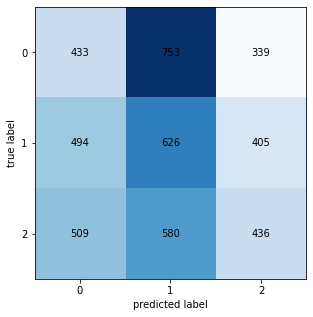

i                precision    recall  f1-score   support

           0       0.30      0.28      0.29      1525
           1       0.32      0.41      0.36      1525
           2       0.37      0.29      0.32      1525

    accuracy                           0.33      4575
   macro avg       0.33      0.33      0.32      4575
weighted avg       0.33      0.33      0.32      4575



In [ ]:
# ## Modelling with features selected by Tree based method
# model_name=['NaiveBayesClassifier','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']
# models_list= [NB(),RF(),KNN(),GB(),AB(),DT()]
# for i, j in zip(model_name, models_list):
#     scores = cross_val_score(j, New_features, y_train, cv = 10)
#     print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#     classifier = j
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 5))
#     plt.show()
#     print("i ",classification_report(y_test, y_pred))

NaiveBayesClassifier--Accuracy: 0.25 (+/- 0.18)


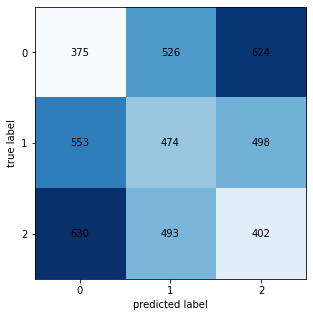

i                precision    recall  f1-score   support

           0       0.24      0.25      0.24      1525
           1       0.32      0.31      0.31      1525
           2       0.26      0.26      0.26      1525

    accuracy                           0.27      4575
   macro avg       0.27      0.27      0.27      4575
weighted avg       0.27      0.27      0.27      4575

RandomForestClassifier--Accuracy: 0.30 (+/- 0.20)


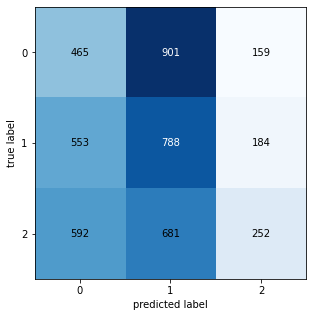

i                precision    recall  f1-score   support

           0       0.29      0.30      0.30      1525
           1       0.33      0.52      0.40      1525
           2       0.42      0.17      0.24      1525

    accuracy                           0.33      4575
   macro avg       0.35      0.33      0.31      4575
weighted avg       0.35      0.33      0.31      4575

KNeighborsClassifier--Accuracy: 0.30 (+/- 0.14)


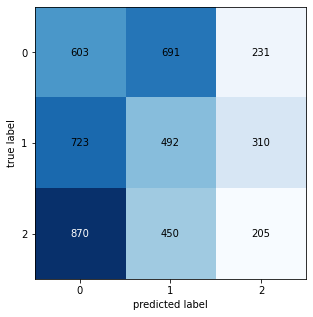

i                precision    recall  f1-score   support

           0       0.27      0.40      0.32      1525
           1       0.30      0.32      0.31      1525
           2       0.27      0.13      0.18      1525

    accuracy                           0.28      4575
   macro avg       0.28      0.28      0.27      4575
weighted avg       0.28      0.28      0.27      4575

GradientBoostingClassifier--Accuracy: 0.32 (+/- 0.19)


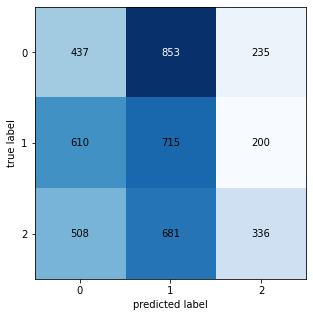

i                precision    recall  f1-score   support

           0       0.28      0.29      0.28      1525
           1       0.32      0.47      0.38      1525
           2       0.44      0.22      0.29      1525

    accuracy                           0.33      4575
   macro avg       0.34      0.33      0.32      4575
weighted avg       0.34      0.33      0.32      4575

AdaBoostClassifier--Accuracy: 0.31 (+/- 0.22)


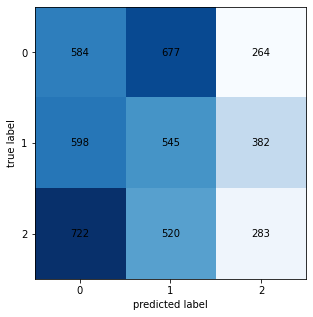

i                precision    recall  f1-score   support

           0       0.31      0.38      0.34      1525
           1       0.31      0.36      0.33      1525
           2       0.30      0.19      0.23      1525

    accuracy                           0.31      4575
   macro avg       0.31      0.31      0.30      4575
weighted avg       0.31      0.31      0.30      4575

DecisionTreeClassifier--Accuracy: 0.34 (+/- 0.13)


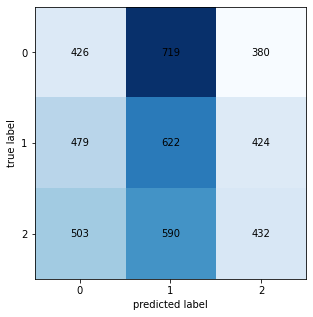

i                precision    recall  f1-score   support

           0       0.30      0.28      0.29      1525
           1       0.32      0.41      0.36      1525
           2       0.35      0.28      0.31      1525

    accuracy                           0.32      4575
   macro avg       0.32      0.32      0.32      4575
weighted avg       0.32      0.32      0.32      4575



In [ ]:
# ## Modelling with features selected by L1 based method
# model_name=['NaiveBayesClassifier','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']
# models_list= [NB(),RF(),KNN(),GB(),AB(),DT()]
# for i, j in zip(model_name, models_list):
#     scores = cross_val_score(j, New_features_2, y_train, cv=10)
#     print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#     classifier = j
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 5))
#     plt.show()
#     print("i ",classification_report(y_test, y_pred))

In [ ]:
## SVM Classifier on whole feature set
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [ ]:
## Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

## View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

## View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.29799490300471754 

Best C: 1 

Best Kernel: rbf 

Best Gamma: 0.0001 



In [ ]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)

## Making the Confusion Matrix
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))

print("Training set score for SVM: %f" % final_model.score(X_train , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test  , y_test ))

## svm_model.score

[[   0   93 1432]
 [   0  148 1377]
 [   0  168 1357]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1525
           1       0.36      0.10      0.15      1525
           2       0.33      0.89      0.48      1525

    accuracy                           0.33      4575
   macro avg       0.23      0.33      0.21      4575
weighted avg       0.23      0.33      0.21      4575



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training set score for SVM: 0.346961
Testing  set score for SVM: 0.328962
